# Fudan RPML Assignment2: Deep Learning Meets News

![news](./news.png)

**Your name and Student ID: [李培基], [20307140044]**

Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

In this assignment, you will build a **text classification** system which is a fundamental task in the field of Natural Language Processing (NLP). More precisely, you are given a news classification task, assigning given news texts to the categories to which they belong. Unlike traditional classification tasks, **we did not provide you with any labels for this assignment, and you need to find a way to construct labels for these articles**. 

For this assignment you can use commonly used deep learning frameworks like paddle and pytorch, and **should use at least one kind of deep neural network for this task**. **You can use pretrained word vectors like Glove, but not pretrained large models like BERT.**

# 1. Setup

In [15]:
# setup code
%load_ext autoreload
%autoreload 2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import jieba
args = {
    'learning_rate':0.0004, 
    'first_momentum':0.9,
    'second_momentum':0.999,
    'batch_size':32,
    'len_feature':300, # embedding_dim
    'hidden_size':50,
    'dropout':0.5,
    'iter_times':50,
    'num_class':4
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset_path = 'assignment2_news.pkl'

all_data = None
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)

print(all_data[10343])
print(all_data[78883])
# 明显，这是一个中文新闻标题数据集

什么企业适合开展融资租赁业务？你不看，真的吃大亏了！
你见过苗寨里待客的方式吗？网友调侃：这才是真正的不醉不归啊！


# 2. Exploratory Data Analysis (5 points)

数据集句子总数 83360
数据集字符最长/最短长度: 145 / 2
数据集中最长字符的句子:
 【定了！中日双方签署有关经贸合作协议】5月9日，在李克强总理和安倍晋三首相共同见证下，中国商务部钟山部长与日本经济产业大臣世耕弘成共同签署了《关于加强服务贸易合作的备忘录》，中国国家发展改革委、商务部与日本外务省、经济产业省共同签署了《关于中日第三方市场合作的备忘录》。详细内容，请戳大图↓
数据集中最短字符的句子:
 美国
数据集中句子字符长度平均值: 22.235280710172745
数据集中句子字符长度超过 50 的句子数目: 66 / 83360
因此结合句子长度分布图，我们有理由在后续处理时对句子长度进行截取


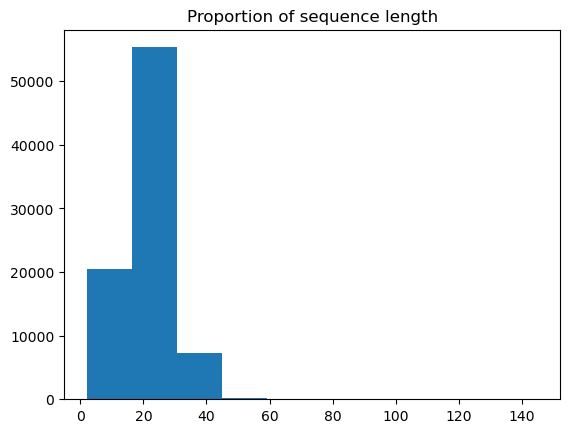

In [24]:
%matplotlib inline
print('数据集句子总数',len(all_data))
min_len = 9999
max_len = 0
id_1 = -1
id_2 = -1
len_list = []
for idx,sentence in enumerate(all_data,0):
    l = len(sentence)
    if l > max_len:
        max_len = l
        id_1 = idx
    if l < min_len:
        min_len = l
        id_2 = idx
    len_list.append(l)
print('数据集字符最长/最短长度:',max_len,'/',min_len)
print('数据集中最长字符的句子:\n',all_data[id_1])
print('数据集中最短字符的句子:\n',all_data[id_2])
print('数据集中句子字符长度平均值:',sum(len_list)/len(len_list))
print('数据集中句子字符长度超过 50 的句子数目:',sum(np.array(len_list) > 50),'/',len(all_data))
print('因此结合句子长度分布图，我们有理由在后续处理时对句子长度进行截取')
plt.title('Proportion of sequence length')
plt.hist(len_list)
plt.show()

In [50]:
import jieba
seg_list = jieba.cut("【定了！中日双方签署有关经贸合作协议】5月9日，在李克强总理和安倍晋三首相共同见证下，中国商务部钟山部长与日本经济产业大臣世耕弘成共同签署了《关于加强服务贸易合作的备忘录》，中国国家发展改革委、商务部与日本外务省、经济产业省共同签署了《关于中日第三方市场合作的备忘录》。详细内容，请戳大图↓")  # 默认是精确模式
print(seg_list)
print(" ".join(seg_list))
seg_list = jieba.lcut("【定了！中日双方签署有关经贸合作协议】5月9日，在李克强总理和安倍晋三首相共同见证下，中国商务部钟山部长与日本经济产业大臣世耕弘成共同签署了《关于加强服务贸易合作的备忘录》，中国国家发展改革委、商务部与日本外务省、经济产业省共同签署了《关于中日第三方市场合作的备忘录》。详细内容，请戳大图↓")
print(seg_list) 

<generator object Tokenizer.cut at 0x7f5b1d37b2a0>
【 定 了 ！ 中日 双方 签署 有关 经贸合作 协议 】 5 月 9 日 ， 在 李克强 总理 和 安倍晋三 首相 共同 见证 下 ， 中国 商务部 钟山 部长 与 日本 经济 产业 大臣 世耕弘成 共同 签署 了 《 关于 加强 服务 贸易 合作 的 备忘录 》 ， 中国 国家 发展 改革 委 、 商务部 与 日本外务省 、 经济 产业省 共同 签署 了 《 关于 中日 第三方 市场 合作 的 备忘录 》 。 详细 内容 ， 请 戳 大图 ↓
['【', '定', '了', '！', '中日', '双方', '签署', '有关', '经贸合作', '协议', '】', '5', '月', '9', '日', '，', '在', '李克强', '总理', '和', '安倍晋三', '首相', '共同', '见证', '下', '，', '中国', '商务部', '钟山', '部长', '与', '日本', '经济', '产业', '大臣', '世耕弘成', '共同', '签署', '了', '《', '关于', '加强', '服务', '贸易', '合作', '的', '备忘录', '》', '，', '中国', '国家', '发展', '改革', '委', '、', '商务部', '与', '日本外务省', '、', '经济', '产业省', '共同', '签署', '了', '《', '关于', '中日', '第三方', '市场', '合作', '的', '备忘录', '》', '。', '详细', '内容', '，', '请', '戳', '大图', '↓']


# 3. Construct the Labels (40 points)

在这个阶段中可以先暂时不划分训练测试验证集

In [3]:
# 加载预训练的word_embedding [365076,300]
with open('sgns.sogou.char','rb') as f:
    lines = f.readlines()
    
trained_dict = dict()
n = len(lines)  # 为预训练文件总行数
embedding_dim = len(lines[1].split())-1
for i in range(1,n):
    # 因为第一行不是数据 共365076的词/字 每个被映射到300维空间
    line = lines[i].split()
    trained_dict[line[0].decode('utf-8')] = [float(line[j]) for j in range(1,embedding_dim+1)]

In [4]:
# 用jieba 进行中文分词
data = []
for sentence in all_data:
    seg_list = jieba.lcut(sentence)
    data.append(seg_list)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.132 seconds.
Prefix dict has been built successfully.


In [57]:
# 使用中文分词后 数据集句子的长度分析
print('数据集句子总数',len(data))
min_len = 9999
max_len = 0
id_1 = -1
id_2 = -1
len_list = []
for idx,sentence in enumerate(data,0):
    l = len(sentence)
    if l > max_len:
        max_len = l
        id_1 = idx
    if l < min_len:
        min_len = l
        id_2 = idx
    len_list.append(l)
print('数据集最长/最短长度:',max_len,'/',min_len)
print('数据集中最多词的句子:\n',data[id_1])
print('数据集中最少词的句子:\n',data[id_2])
print('数据集中词长度长度平均值:',sum(len_list)/len(len_list))
print('数据集中词数量超过 30 的句子数目:',sum(np.array(len_list) > 30),'/',len(data))

数据集句子总数 83360
数据集最长/最短长度: 85 / 1
数据集中最多词的句子:
 ['这个', '周日', '#', '母亲节', '#', ' ', '又', '要', '到', '啦', '！', '我们', '特别', '采访', '了', '田径队', '的', '小伙伴', '们', '，', '请', '他们', '回答', '了', '几个', '关于', '妈妈', '的', '问题', '~', '他们', '最爱', '吃', '妈妈', '做', '的', '哪', '道菜', '？', '[', '爱慕', ']', '最想', '送给', '妈妈', '什么', '礼物', '？', '[', '礼物', ']', '你', '的', '答案', '和', '他们', '一样', '吗', '？', '你', '对', '妈妈', '有', '怎样', '的', '祝福', '？', '前进', '的', '路上', '，', '不负', '光阴', '，', '和', '我们', '一起', '#', '为', '妈妈', '而战', '#', ' ', '！', ' ']
数据集中最少词的句子:
 ['美国']
数据集中词长度长度平均值: 12.945165547024953
数据集中词数量超过 30 的句子数目: 62 / 83360


In [19]:
import torch
class Embedding():
    def __init__(self,trained_dict,data,args) -> None:
        self.dict_words = {}    # 单词映射到自然数的字典
        self.sentence_matrix = []   # 数据集中句子的矩阵表示（每个词为一个自然数）
        self.embedding_matrix = [] # embedding矩阵，每个word_vector对应的下标id为相应的词
        self.trained_dict = trained_dict  # 预训练的词典：词与word_vector的对应
        self.embedding_dim = args['len_feature']
        self.data = data
    
    def get_words(self):
        '''
        此函数的目标是建立单词与自然数的映射的词典,同时建立好embedding_weight矩阵,并不处理数据集
        '''
        self.embedding_matrix.append([0]*300) # [PAD] id:0
        self.embedding_matrix.append([0]*300) # [UNK] id:1
        self.dict_words['[PAD]'] = 0
        self.dict_words['[UNK]'] = 1
        for word in self.trained_dict.keys():
            if word not in self.dict_words:
                self.dict_words[word] = len(self.dict_words) + 2
                self.embedding_matrix.append(self.trained_dict[word])
        mean = torch.mean(torch.tensor(self.embedding_matrix))
        std = torch.std(torch.tensor(self.embedding_matrix))
        unknown_vec = torch.normal(mean,std,size = [1,self.embedding_dim]).reshape(-1)
        self.embedding_matrix[1] = unknown_vec.tolist()    # for [UNK]： Gaussian Sample 有的论文做法
    
    def get_id(self):
        '''
        这个函数目的是给数据集中的句子建立成矩阵，每个句子表示为一串id，对应着 embedding矩阵的 下标
        '''
        for sentence in self.data:
            item = []
            for word in sentence:
                if word not in self.dict_words:
                    item.append(self.dict_words['[UNK]'])
                else:
                    item.append(self.dict_words[word])
            self.sentence_matrix.append(item)

In [20]:
ebd = Embedding(trained_dict=trained_dict,data=data,args=args)
ebd.get_words()

In [21]:
ebd.get_id()

# 4. News Classification (50 points)

# 5. Conclusion (5 points)

# Reference
List your references here.